<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Logistic Regression**


Estimated time needed: **30** minutes


In this lab, you will learn about and get hands-on practice with the logistic regression model, a popular and effective classification model. Understanding logistic regression and being able to apply it to classification tasks is essential because logistic regression models form the fundamentals of neural networks.


We will use a real-world dataset that contains detailed nutrition information about food items for people with diabetes. The objective is to classify whether a diabetic patient should choose More Often, Less Often, or In Moderation for a specific food item based on the nutrition information in the dataset.


## Objectives


After completing this lab you will be able to:


*   Preprocess and generate training and testing datasets
*   Train and fine-tune logistic regression models
*   Interpret trained logistic regression models
*   Evaluate trained logistic regression models


***


## Prepare and setup lab environment


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0
# Note: If your environment doesn't support "!mamba install", use "!pip install"

In [1]:
import piplite as pl
await pl.install(['numpy','pandas','scikit-learn','seaborn'])

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [3]:
# also set a random state
rs = 123

### Exploratory Data Analysis(EDA) and Feature Engineering
Before we get to the model implementation, it is essential to examine the dataset and carefully select the features that will serve as inputs for the model..


### Load and explore the dataset


First, let's load the dataset as a `Pandas` dataframe and conduct some basic EDA tasks on it.


In [4]:
import pyodide_http as ph
ph.patch_all()
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/food_items.csv"
food_df = pd.read_csv(dataset_url)

And, let's quickly check its column types.


In [5]:
food_df.dtypes

Calories               float64
Total Fat                int64
Saturated Fat          float64
Monounsaturated Fat    float64
Polyunsaturated Fat    float64
Trans Fat              float64
Cholesterol              int64
Sodium                 float64
Total Carbohydrate     float64
Dietary Fiber          float64
Sugars                 float64
Sugar Alcohol            int64
Protein                float64
Vitamin A                int64
Vitamin C                int64
Calcium                  int64
Iron                     int64
class                   object
dtype: object

Print the first ten food items:


In [6]:
food_df.head(10)

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron,class
0,149.0,0,0.0,0.0,0.0,0.0,0,9.0,9.8,0.0,0.0,0,1.3,0,0,0,0,'In Moderation'
1,123.0,0,0.0,0.0,0.0,0.0,0,5.0,6.6,0.0,0.0,0,0.8,0,0,0,0,'In Moderation'
2,150.0,0,0.0,0.0,0.0,0.0,0,4.0,11.4,0.0,0.0,0,1.3,0,0,0,0,'In Moderation'
3,110.0,0,0.0,0.0,0.0,0.0,0,6.0,7.0,0.0,0.0,0,0.8,0,0,0,0,'In Moderation'
4,143.0,0,0.0,0.0,0.0,0.0,0,7.0,13.1,0.0,0.0,0,1.0,0,0,0,0,'In Moderation'
5,110.0,0,0.0,0.0,0.0,0.0,0,6.0,7.0,0.0,0.0,0,0.8,0,0,0,0,'In Moderation'
6,142.0,0,0.0,0.0,0.0,0.0,0,12.0,10.6,0.0,0.0,0,1.2,0,0,0,0,'In Moderation'
7,102.0,0,0.0,0.0,0.0,0.0,0,13.0,5.0,0.0,0.0,0,0.7,0,0,0,0,'In Moderation'
8,145.0,0,0.0,0.0,0.0,0.0,0,17.0,11.0,0.0,0.0,0,1.2,0,0,0,0,'In Moderation'
9,171.0,0,0.0,0.0,0.0,0.0,0,8.0,13.7,0.0,0.0,0,2.5,0,0,0,0,'In Moderation'


In [7]:
food_df['class'].value_counts()

class
'In Moderation'    6649
'Less Often'       5621
'More Often'        990
Name: count, dtype: int64

Get the row entries with col 0 to -1 (16).


In [8]:
feature_cols = list(food_df.columns[:-1])
feature_cols

['Calories',
 'Total Fat',
 'Saturated Fat',
 'Monounsaturated Fat',
 'Polyunsaturated Fat',
 'Trans Fat',
 'Cholesterol',
 'Sodium',
 'Total Carbohydrate',
 'Dietary Fiber',
 'Sugars',
 'Sugar Alcohol',
 'Protein',
 'Vitamin A',
 'Vitamin C',
 'Calcium',
 'Iron']

Obtain descriptive statistics:


In [9]:
food_df.describe()

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron
count,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000,13260.000000
mean,133.861086,4.475264,1.450617,0.338069,0.254660,0.047459,8.857692,241.867142,18.232020,1.602971,6.645234,0.117949,4.661333,6.287632,6.741855,5.175264,5.235671
std,94.227650,5.386340,2.410318,1.345852,2.230586,0.321402,20.976530,272.284363,14.786316,3.363879,8.328465,1.121529,5.611143,18.374191,23.785100,8.779637,9.119459
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,120.000000,3.000000,0.500000,0.000000,0.000000,0.000000,0.000000,135.000000,17.000000,1.000000,3.000000,0.000000,3.000000,0.000000,0.000000,2.000000,2.000000
75%,180.000000,7.000000,2.000000,0.000000,0.000000,0.000000,10.000000,370.000000,27.000000,2.000000,11.000000,0.000000,7.000000,6.000000,2.000000,6.000000,8.000000
max,2210.000000,43.000000,22.000000,40.000000,235.000000,11.000000,450.000000,2431.000000,270.000000,305.000000,115.000000,31.000000,70.000000,622.000000,1000.000000,110.000000,170.000000


As we can see from the above output, this dataset contains 17 nutrient categories about each food item. These categories include Calories, Total Fat, Protein, Sugar, etc., and are listed as numeric variables. As such, we only need to scale them for training our logistic regression model so that we can compare our feature coefficients directly. This will be done under the feature engineering section.


Next, let's check the target variable in the `class` column to see the label values and their distribution.


In [10]:
# # Get the row entries with the last col 'class'
food_df.iloc[:, -1].value_counts(normalize=True)

class
'In Moderation'    0.501433
'Less Often'       0.423906
'More Often'       0.074661
Name: proportion, dtype: float64

<Axes: xlabel='class'>

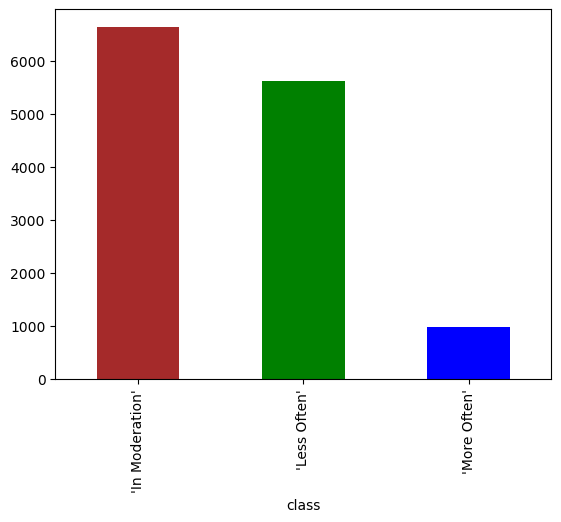

In [11]:
food_df.iloc[:, -1].value_counts().plot.bar(color=['brown','green','blue'])

As we can see from the bar chart above, this dataset has three classes: `In Moderation`, `Less Often`, and `More Often`. The three labels are imbalanced. For diabetic patients, most food items are in the In Moderation and Less Often categories. This makes diabetes diet management very hard, so we could build a machine learning model to help patients choose their food.


We have three labels meaning our logistic regression model will be multinomial with three classes.

A multinomial logistic regression is a generalized logistic regression model which generates a probability distribution over all classes, based on the logits or exponentiated log-odds calculated for each class (usually more than two).


Also note that a multinomial logistic regression model is different from the `one-vs-rest` binary logistic regression. For `one-vs-rest` schema, you need to train an independent classifier for each class. For example, you need a `More Often` classifier to differentiate a food item between `More Often` and `Not More Often` (or, `In Moderation` and `Less Often`).


### Feature Engineering


Now you should have some basic understanding about the food dataset. Next, let's process the raw dataset and construct input data `X` and label/output `y` for logistic regression model training.


In [12]:
X_raw = food_df.iloc[:, :-1]
y_raw = food_df.iloc[:, -1]

In [13]:
X_raw.shape, y_raw.shape

((13260, 17), (13260,))

Fortunately, all feature columns are numeric so we just need to scale them. Here we use the `MinMaxScaler` provided by `sklearn` for scaling.


In [14]:
scaler = MinMaxScaler()  # normalization

In [15]:
# before normalization
X_raw.head()

,Calories,Total Fat,Saturated Fat,Monounsaturated Fat,Polyunsaturated Fat,Trans Fat,Cholesterol,Sodium,Total Carbohydrate,Dietary Fiber,Sugars,Sugar Alcohol,Protein,Vitamin A,Vitamin C,Calcium,Iron
0,149.0,0,0.0,0.0,0.0,0.0,0,9.0,9.8,0.0,0.0,0,1.3,0,0,0,0
1,123.0,0,0.0,0.0,0.0,0.0,0,5.0,6.6,0.0,0.0,0,0.8,0,0,0,0
2,150.0,0,0.0,0.0,0.0,0.0,0,4.0,11.4,0.0,0.0,0,1.3,0,0,0,0
3,110.0,0,0.0,0.0,0.0,0.0,0,6.0,7.0,0.0,0.0,0,0.8,0,0,0,0
4,143.0,0,0.0,0.0,0.0,0.0,0,7.0,13.1,0.0,0.0,0,1.0,0,0,0,0


In [16]:
# Scaling the raw input features
X = scaler.fit_transform(X_raw)

In [17]:
X[:5]

array([[0.06742081, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00370218, 0.0362963 , 0.        ,
        0.        , 0.        , 0.01857143, 0.        , 0.        ,
        0.        , 0.        ],
       [0.05565611, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00205677, 0.02444444, 0.        ,
        0.        , 0.        , 0.01142857, 0.        , 0.        ,
        0.        , 0.        ],
       [0.0678733 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00164541, 0.04222222, 0.        ,
        0.        , 0.        , 0.01857143, 0.        , 0.        ,
        0.        , 0.        ],
       [0.04977376, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00246812, 0.02592593, 0.        ,
        0.        , 0.        , 0.01142857, 0.        , 0.        ,
        0.        , 0.        ],
       [0.06470588, 0.        , 0.        , 0.      

Let's check the scaled feature value range:


In [18]:
print(f"The range of feature inputs are within {X.min()} to {X.max()}")

The range of feature inputs are within 0.0 to 1.0


For the target variable `y`, let's use the `LabelEncoder` provided by `sklearn` to encode its three class values.


In [19]:
label_encoder = LabelEncoder() # for dependent variable (y)

In [20]:
y_raw.values.shape

(13260,)

In [21]:
y_raw.values.ravel() # convert 2D arrays to 1D array

array(["'In Moderation'", "'In Moderation'", "'In Moderation'", ...,
       "'In Moderation'", "'In Moderation'", "'In Moderation'"],
      dtype=object)

In [22]:
h = label_encoder.fit_transform(y_raw.values)

In [23]:
# Encode the target variable
y = label_encoder.fit_transform(y_raw.values.ravel()) 
# in this case not require `.ravel()'

In [25]:
(h == y).any()

np.True_

The encoded target variable will only contain values `0=In Moderation`, `1=Less Often`, `2=More Often`.


In [26]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([6649, 5621,  990]))

|values | counts |
|-------|--------|
| 0 | 6649 |
| 1 | 5621 |
| 2 |  990 |


**0** = `In Moderation`  
**1** = `Less Often`  
**2** = `More Often`

## Train logistic regression models


First, let's split the dataset into a training and a testing dataset. Training dataset will be used to train and (maybe) tune models, and testing dataset will be used to evaluate the models. Note that you may also split the training dataset into train and validation sets where the validation dataset is only used to tune the model and to set the model parameters.


In [27]:
# First, let's split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

```python
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)
```  
`stratify=y` is used in this code since value counts in 'y' are not balanced. It is significant for large datasets.

Let's look at the shapes of the split datasets:


In [28]:
# check value counts in y_train
print("y_train:", np.unique(y_train, return_counts=True))
# check value counts in y_test
print("y_test:", np.unique(y_test, return_counts=True))

y_train: (array([0, 1, 2]), array([5319, 4497,  792]))
y_test: (array([0, 1, 2]), array([1330, 1124,  198]))


In [29]:
# Let's try without stratification
H_train, H_test, a_train, a_test = train_test_split(X, y, test_size=0.2, random_state=rs)
print("a_train:", np.unique(a_train, return_counts=True))
print("a_test:", np.unique(a_test, return_counts=True))

a_train: (array([0, 1, 2]), array([5305, 4512,  791]))
a_test: (array([0, 1, 2]), array([1344, 1109,  199]))


In [30]:
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")

Training dataset shape, X_train: (10608, 17), y_train: (10608,)


In [31]:
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Testing dataset shape, X_test: (2652, 17), y_test: (2652,)


OK, now we have the training and testing datasets ready, let's start the model training task.


We first define a `sklearn.linear_model.LogisticRegression` model with the following arguments, you can check the comment for each argument for what it means.


In [32]:
# L2 penalty to shrink coefficients without removing any features from the model
penalty= 'l2'

# Our classification problem is multinomial coz y values has [0,1,2]
multi_class = 'multinomial'

# Use lbfgs for L2 penalty and multinomial classes
solver = 'lbfgs'

# Max iteration = 1000
max_iter = 1000

**From ChatGPT**:  
The `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) solver is an optimization algorithm used in logistic regression to find the best model parameters. It is particularly useful for small to medium-sized datasets.

In [33]:
# Define a logistic regression model with above arguments
l2_model = LogisticRegression(random_state=rs, penalty=penalty, 
                              multi_class=multi_class, solver=solver, 
                              max_iter=max_iter)

Let's train the model with training input data `X_train` and labels `y_train`:


In [34]:
l2_model.fit(X_train, y_train)

/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=123)

In [35]:
l2_preds = l2_model.predict(X_test)
np.unique(l2_preds)

array([0, 1, 2])

In [36]:
label_encoder.inverse_transform(l2_preds)

array(["'Less Often'", "'Less Often'", "'In Moderation'", ...,
       "'In Moderation'", "'In Moderation'", "'Less Often'"], dtype=object)

In [37]:
# Checking the results by comparing
pd.DataFrame({'test_value': label_encoder.inverse_transform(y_test), 
              'pred_value': label_encoder.inverse_transform(l2_preds)}).sample(10)

,test_value,pred_value
803,'Less Often','In Moderation'
2439,'Less Often','Less Often'
2304,'Less Often','In Moderation'
1239,'Less Often','Less Often'
1632,'In Moderation','In Moderation'
1366,'Less Often','Less Often'
163,'Less Often','In Moderation'
898,'More Often','In Moderation'
505,'In Moderation','In Moderation'
265,'More Often','In Moderation'


Because we may need to evaluate the model multiple times with different model hyper parameters, here we define an utility method to take the ground truths `y_test` and the predictions `preds`, and return a Python `dict` with `accuracy`, `recall`, `precision`, and `f1score`.


In [39]:
# Test defined function first
results = {}
results['accuracy'] = accuracy_score(y_test, l2_preds)
x, y, z = 'precision', 'recall', 'f1_score'
results[x], results[y], results[z], _ = precision_recall_fscore_support(y_test, l2_preds)

results

{'accuracy': 0.7748868778280543,
 'precision': array([0.73035827, 0.83553299, 0.92105263]),
 'recall': array([0.87368421, 0.73220641, 0.35353535]),
 'f1_score': array([0.79561794, 0.78046468, 0.51094891])}

In [44]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1_score'] = f_beta
    return results_pos

In [45]:
evaluate_metrics(y_test, l2_preds)

{'accuracy': 0.7748868778280543,
 'recall': array([0.87368421, 0.73220641, 0.35353535]),
 'precision': array([0.73035827, 0.83553299, 0.92105263]),
 'f1_score': array([0.79561794, 0.78046468, 0.51094891])}

As we can see from  the above evaluation results, the logistic regression model has relatively good performance on this multinomial classification task. The overall accuracy is around `0.77` and the f1score is around `0.8`. Note that for `recall`, `precision`, and `f1_score`, we output the values for each class to see how the model performs on an individual class. And, we can see from the results, the recall for `class=2` (More often) is not very good. This is actually a common problem called imbalanced classification challenge. We will introduce solution to this problem later in this course.


Next, let's try defining another logistic regression model with l1 penality this time, to see if our classification performance would be improved.


In [ ]:
# L1 penalty to shrink coefficients without removing any features from the model
penalty= 'l1'
# Our classification problem is multinomial
multi_class = 'multinomial'
# Use saga for L1 penalty and multinomial classes
solver = 'saga'
# Max iteration = 1000
max_iter = 1000

Then we define another logistic regression model with above arguments using l1 penality and related solver.


In [ ]:
# Define a logistic regression model with above arguments
l1_model = LogisticRegression(random_state=rs, penalty=penalty, multi_class=multi_class, solver=solver, max_iter = 1000)

We can start to train the new `l1_model` with the new taining dataset.


In [ ]:
l1_model.fit(X_train, y_train)

And, make predictions using the input in the test dataset.


In [ ]:
l1_preds = l1_model.predict(X_test)

We can also check the class probability distribution using the `predict_proba` function. For example, we want to see the probabilities of belonging to each class for the first instance in the test dataset:


In [ ]:
odd_ratios = l1_model.predict_proba(X_test[:1, :])[0]
odd_ratios

We can see that  Class 1 has the largest probability 0.96. As such, the model prediction for this instance will be class `1` and this is the same as the `predict` method.


In [ ]:
l1_model.predict(X_test[:1, :])[0]

Given the true labels (`y_test`) and predictions, we can evaluate the model performance by calling the utility `evaluate_metrics`  method.


In [ ]:
evaluate_metrics(y_test, l1_preds)

Now, we can see this logistic regression with l1 penalty has much better performance than l2. One possible reason is that l1 penalty may remove some correlated feature variables by shrinking their coefficents to zero. As such, the model is much simplified to avoid overfitting on the training data and better aligned with the logistic regression assumption that all features should be independent.


### Confusion Matrix


We can also plot the confusion matrix based on the true labels and predictions using the `confusion_matrix` method provided by `sklearn`,


In [ ]:
cf = confusion_matrix(y_test, l1_preds, normalize='true')

and easily visualize it using a heatmap method provided by `seaborn`.


In [ ]:
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=l1_model.classes_)
disp.plot()
plt.show()

### Interpret logistic regression models


One way to interpret logistic regression models is by analyzing feature coefficients. Although it may not be as effective as the regular linear regression models because the logistic regression model has a sigmoid function, we can still get a sense for the importance or impact of each feature.  


We can check the coefficients for logistic regression model using its `coef_` attribute:


In [ ]:
l1_model.coef_

The `coef_` is a coefficients list with three elements, one element is the actual coefficent for class 0, 1, 2. To better analyze the coefficients, let's use three utility methods to sort and visualize them.


In [ ]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()

Then, let's visualize the sorted coefficient for class 1, the `Less Often` class: 


In [ ]:
# Get the coefficents for Class 1, Less Often
coef_dict = get_feature_coefs(l1_model, 1, feature_cols)

In [ ]:
visualize_coefs(coef_dict)

As we can see, unhealthy nutrients such as Saturated Fat, Sugars, Cholesterol, Total Fat, etc., have high positive coefficients. Food items containing unhealthy nutrients will have higher coeficients and will be more likely to be categorized in the 'Less Often' class.


Next, let's see the coefficents for Class 2, `More Often`:


In [ ]:
# Coefficients for Class 2
coef_dict = get_feature_coefs(l1_model, 2, feature_cols)
visualize_coefs(coef_dict)

Conversely, if a food item has a high amount of calories, total carbohydrates, and total fat, then it is unlikely to be categorized in the 'More Often' class.


## Coding Exercise: Train and evaluate a logistic regression model with elastic-net penality


Now, it's your turn to walk through the end-to-end process of defining, building, evaluating, and interpreting a logistic regression model.


### Define a logistic regression with elastic-net penality


In [ ]:
# Type your code here
# HINT: sklearn only support saga solver for elastic-net penality
# and you need to set another l1_ratio to be within 0 < l1_ratio <1, in order to actually use elastic-net


### Train the model with training data


In [ ]:
# Type your code here


### Evaluate the model using accuracy, precision, recall, and F1score


In [ ]:
# Type your code here


### Plot confusion matrix


In [ ]:
# Type your code here


### Interpret the model by analysing its coefficients


In [ ]:
# Type your code here


<details><summary>Click here for a sample solution</summary>

```python
# elasticnet penalty to shrink coefficients without removing any features from the model
penalty= 'elasticnet'
# Our classification problem is multinomial
multi_class = 'multinomial'
# Use saga for L1 penalty and multinomial classes
solver = 'saga'
# Max iteration = 1000
max_iter = 1000
# l1_ratio
l1_ratio = 0.1

# Define a elastic-net model
en_model = LogisticRegression(random_state=rs, penalty=penalty, multi_class=multi_class, solver=solver, max_iter = 1000, l1_ratio=l1_ratio)
en_model.fit(X_train, y_train)
# Make predictions
preds = en_model.predict(X_test)
```

</details>


## Next steps


Great! Now you have learned about and practiced applying a logistic regression model to solve a real-world food classification problem for diabetic patients. You also learned how to evaluate and interpret the trained logistic regression models.


Next, you will be learning other popular classification models with different structures, assumptions, cost functions, and application scenarios.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2021-01-01)


### Other Contributors


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By | Change Description          |
| ----------------- | ------- | ---------- | --------------------------- |
| 2021-10-25        | 1.0     | Yan        | Created the initial version |
--!>


Copyright © 2021 IBM Corporation. All rights reserved.
